In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix 

In [8]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from src.dataset import BrainTumorDataset, get_transforms, CLASS_NAMES
from src.utils import calculate_accuracy

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
weights_path="../models/resnet18_brain_mri.pt"

In [12]:
def load_model(weights_path=weights_path):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 4)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()
    model.to(device)
    return model

model = load_model()

In [13]:
test_dir = "../data/Testing/"

def evaluate_model(model, test_dir=test_dir, batch_size=32):
    ds = BrainTumorDataset(test_dir, transform=get_transforms())
    loader = DataLoader(ds, batch_size=batch_size)

    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return report, cm

report, cm = evaluate_model(model)

In [16]:
import pandas as pd
import seaborn as sns

In [15]:
pd.DataFrame(report).T

,precision,recall,f1-score,support
glioma,0.996622,0.983333,0.989933,300.000000
meningioma,0.980519,0.986928,0.983713,306.000000
pituitary,0.993355,0.996667,0.995008,300.000000
notumor,0.997537,1.000000,0.998767,405.000000
accuracy,0.992372,0.992372,0.992372,0.992372
macro avg,0.992008,0.991732,0.991855,1311.000000
weighted avg,0.992399,0.992372,0.992372,1311.000000


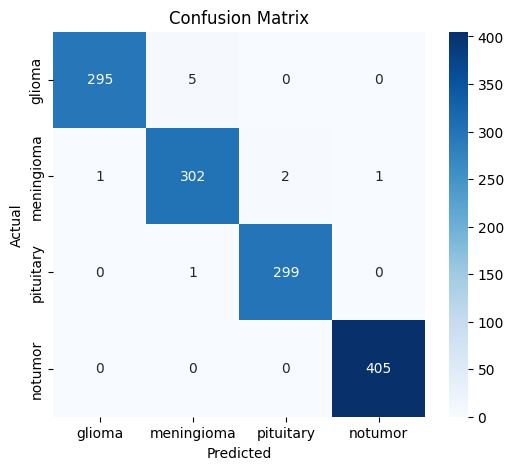

In [17]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
def predict_image(model, image_path):
    image = Image.open(image_path).convert("RGB")
    transform = get_transforms()
    tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred_class = torch.max(probs, dim=1)

    return {
        "class": CLASS_NAMES[pred_class.item()],
        "confidence": round(conf.item(), 4),
        "probs": probs.squeeze().cpu().numpy()
    }


image_path = "../data/Testing/meningioma/Te-me_0013.jpg"
result = predict_image(model, image_path)
print(result)

{'class': 'meningioma', 'confidence': 1.0, 'probs': array([3.9424748e-08, 9.9999988e-01, 1.7104649e-09, 7.4326742e-08],
      dtype=float32)}


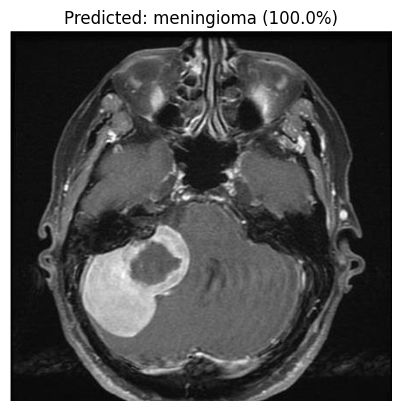

In [21]:
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {result['class']} ({result['confidence']*100:.1f}%)")
plt.show()